In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [2]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [4]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs


In [5]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


In [6]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T,Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transientterm = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1]*(1/self._dt))        
        # Calculate the linearization coefficient
        coefftransient = self._rho*self._cp*self._grid.vol*(1/self._dt)  
        # Add to coefficient arrays
        coeffs.accumulate_aP(coefftransient)
        coeffs.accumulate_rP(transientterm)
        return coeffs

In [7]:
#from Lesson3.Grid import Grid
#from Lesson3.ScalarCoeffs import ScalarCoeffs
#from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
#from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
#from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 10
dt = 50
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 1000
k = 100

# Define convection parameters
ho = 25
To = 200

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Timestep = 0; Time = 50
Iteration = 0; Max. Resid. = 294000.00000000006; Avg. Resid. = 293800.00000000006
Iteration = 1; Max. Resid. = 14405944.65959777; Avg. Resid. = 13568611.169573465
Iteration = 2; Max. Resid. = 705875650.7523494; Avg. Resid. = 637784489.117878
Iteration = 3; Max. Resid. = 34585441818.9332; Avg. Resid. = 30255211301.23507
Iteration = 4; Max. Resid. = 1694400028248.6472; Avg. Resid. = 1442701238896.197
Iteration = 5; Max. Resid. = 82998143272472.0; Avg. Resid. = 69014576413402.06
Iteration = 6; Max. Resid. = 4064611326573096.0; Avg. Resid. = 3308537393977494.5
Iteration = 7; Max. Resid. = 1.9899193969678074e+17; Avg. Resid. = 1.588545862975098e+17
Iteration = 8; Max. Resid. = 9.738394095296102e+18; Avg. Resid. = 7.636065187625114e+18
Iteration = 9; Max. Resid. = 4.7637423843162404e+20; Avg. Resid. = 3.673991525762572e+20
Timestep = 1; Time = 100
Iteration = 0; Max. Resid. = 2.282567990211593e+22; Avg. Resid. = 1.73364112766875e+22
Iteration = 1; Max. Resid. = 1.1154

[400. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.]
[4.00000000e+02 3.12088619e+18 8.98100666e+18 1.38585177e+19
 1.75025235e+19 1.99807103e+19 2.15347457e+19 2.24425632e+19
 2.29387255e+19 2.31883180e+19 2.32904678e+19 2.32904678e+19]
[4.00000000e+02 1.67774114e+35 4.94090894e+35 7.94303093e+35
 1.05580713e+36 1.27167831e+36 1.44057875e+36 1.56546863e+36
 1.65171144e+36 1.70515244e+36 1.73055477e+36 1.73055477e+36]
[4.00000000e+02 1.05823139e+52 3.13585907e+52 5.10085812e+52
 6.89025248e+52 8.45661152e+52 9.76976012e+52 1.08154259e+53
 1.15914703e+53 1.21028003e+53 1.23562000e+53 1.23562000e+53]
[4.00000000e+02 7.05208182e+68 2.09478798e+69 3.42313592e+69
 4.65348749e+69 5.75449834e+69 6.70123350e+69 7.47529128e+69
 8.06417486e+69 8.46016943e+69 8.65906417e+69 8.65906417e+69]
[4.00000000e+02 4.80525703e+85 1.42878474e+86 2.33919147e+86
 3.18820135e+86 3.95461074e+86 4.62014334e+86 5.16976950e+86
 5.59177960e+86 5.87767479e+86 6.02196440e+86 6.02196440e+86]
[4.00000000e+002 3

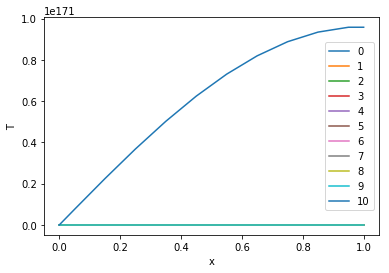

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    print(T)
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [9]:
A = [3, 4, 6, 7] 
B = [1, 3, 6, 3]
c = [x1 - x2 for (x1, x2) in zip(A, B)]
d = sum (c)
print (d)

7
